In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [23]:
from tensorflow.keras.utils import normalize
import tensorflow as tf
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [2]:
SIZE = 256
num_images = 496

In [10]:
image_names = glob.glob("/content/drive/MyDrive/Research_paper-2023/uavid-patches/uavid_patch_train/Images/*.png")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img) for img in image_names_subset]
images = [cv2.resize(img, dsize=(256,256), interpolation=cv2.INTER_LINEAR) for img in images]
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis = 3)

In [11]:
image_dataset_ex = np.expand_dims(image_dataset, axis = 4)
image_dataset.shape

(496, 256, 256, 3)

In [5]:
mask_names = glob.glob("/content/drive/MyDrive/Research_paper-2023/uavid-patches/uavid_patch_train/Masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask,0) for mask in mask_names_subset]
masks = [cv2.resize(mask, dsize=(256,256), interpolation=cv2.INTER_LINEAR) for mask in masks]
masks = [cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)[1] for mask in masks]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)
mask_dataset.shape

(496, 256, 256, 1)

In [15]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (496, 256, 256, 3)
Mask data shape is:  (496, 256, 256, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0.         0.00392157]


In [14]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #Pixel values will be 0 or 1

In [16]:
# # from sklearn.model_selection import train_test_split
# X_train = image_dataset[0:390]
# X_test = image_dataset[390:]
# Y_train = mask_dataset[0:390]
# Y_test = mask_dataset[390:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

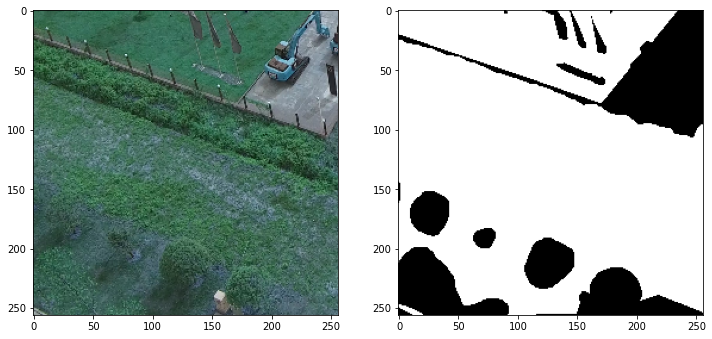

In [20]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,:])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,:], cmap = 'gray')
plt.show()

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)
    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [25]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [26]:
print(X_train[0].shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(256, 256, 3)
(396, 256, 256, 3)
(396, 256, 256, 1)
(100, 256, 256, 3)
(100, 256, 256, 1)


In [27]:
print(input_shape)

(256, 256, 3)


In [28]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

sigmoid


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle = False)

Epoch 1/5
25/25 [==============================] - 64s 2s/step - loss: 0.2437 - accuracy: 0.8409 - val_loss: 11387.3359 - val_accuracy: 0.0069
Epoch 2/5
25/25 [==============================] - 23s 941ms/step - loss: 0.0727 - accuracy: 0.8865 - val_loss: 717.4089 - val_accuracy: 0.0185
Epoch 3/5
25/25 [==============================] - 24s 950ms/step - loss: 0.0476 - accuracy: 0.8865 - val_loss: 2.0306 - val_accuracy: 0.5204
Epoch 4/5
25/25 [==============================] - 23s 920ms/step - loss: 0.0354 - accuracy: 0.8865 - val_loss: 0.8299 - val_accuracy: 0.5368
Epoch 5/5
25/25 [==============================] - 24s 951ms/step - loss: 0.0276 - accuracy: 0.8865 - val_loss: 0.0899 - val_accuracy: 0.8787


In [ ]:
history.history

{'loss': [0.49265724420547485, 0.2996375262737274, 0.28120914101600647],
 'accuracy': [0.7707393169403076, 0.888053297996521, 0.8890894651412964],
 'val_loss': [16637.568359375, 65.6051025390625, 2.454463481903076],
 'val_accuracy': [0.11998855322599411,
  0.14474426209926605,
  0.8788795471191406]}

In [ ]:
model.save('/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/U-net-binary-256x256-rgb-3-latest-epochs.hdf5')

In [ ]:
# #LOad new model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/U-net-binary-256x256-rgb-3-latest-epochs.hdf5')

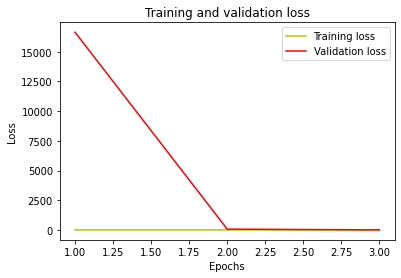

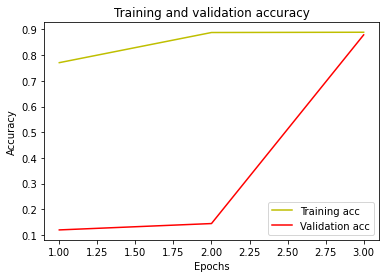

In [ ]:
##training metrics
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
y_pred = model.predict(X_test)
y_pred_mask = y_pred > 0.5
print("predictions shape:", y_pred.shape)

Evaluate on test data
4/4 [==============================] - 10s 376ms/step - loss: 2.4545 - accuracy: 0.8789
test loss, test acc: [2.454463243484497, 0.8788795471191406]
Generate predictions for 3 samples
4/4 [==============================] - 2s 514ms/step
predictions shape: (100, 256, 256, 1)


In [ ]:
for count, pred in enumerate(y_pred):
  filename = '/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/ModelPredictions/Prediction' + str(count) + '.jpg'
  cv2.imwrite(filename, pred)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_mask, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.44040734


In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, axis=0)
print(test_img_input.shape)
print(test_img.shape)

(1, 256, 256, 3)
(256, 256, 3)


In [ ]:
prediction = (model.predict(test_img_input))
print(prediction.shape)
prediction_part = prediction[0,:,:,0]
print(prediction_part.shape)

1/1 [==============================] - 0s 23ms/step
(1, 256, 256, 1)
(256, 256, 1)


(1, 256, 256, 3)
1/1 [==============================] - 0s 23ms/step
(256, 256)


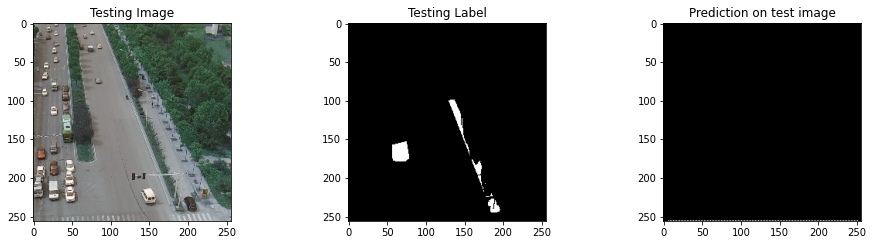

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()